
# plot habitat maps
# Fig.1 & Fig. 2 in paper


In [ ]:
#get_ipython().system(u'jupyter nbconvert --to=python plot_AGI_toothfish_present_vs_future_AGI_habitat_overlap.ipynb')

In [1]:

import xarray as xr
import numpy as np
import sys, os
from pathlib import Path
import glob
import matplotlib.pyplot as plt


In [2]:
#-----
# based on python code provided by Anne
#-----

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list
habitat_all  = np.zeros([360,1440,no_species])
habitat_all2 = np.zeros([360,1440,no_species])

#habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!

# Dec 2024: recreated habitat files with Anne's scripts during review process
# test different thresholds here!
thresh = 0
habitat_files = Path(basepath + "scripts_Anne/AquaMaps/0.5deg_prob_threshold_0."+\
                     str(thresh)+"/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat  = ff['lat'].values 
        lon  = ff['lon'].values 
    ff.close()

    # Get the species name from the full pathname with a space between
    species_names[ifile]  = '_'.join(os.path.basename(file).split('_')[:-2]).replace('_',' ') 
    if not species_names[ifile] in ['Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana']:
        species_names[ifile] = species_names[ifile][8:] # get rid of "Default" or "Reviewed"
    if species_names[ifile][0].isspace():  # get rid of white space if there is any
        species_names[ifile] = species_names[ifile][1:]
    if species_names[ifile] in ['Chionobathyscus dewitti All Suitable Habitat']:
        species_names[ifile] = species_names[ifile][0:23]
    # Get the species name from the full pathname with _ in it
    species_names_[ifile] = species_names[ifile].replace(' ','_')  #'_'.join(os.path.basename(file).split('_')[:-2]) 

# SECOND THRESHOLD
# Dec 2024: recreated habitat files with Anne's scripts during review process
# test different thresholds here!
thresh2 = 8
habitat_files = Path(basepath + "scripts_Anne/AquaMaps/0.5deg_prob_threshold_0."+\
                     str(thresh2)+"/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all2[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat  = ff['lat'].values 
        lon  = ff['lon'].values 
    ff.close()
    
#print(habitat_file_names)
print(species_names)
print(len(species_names),'species')
print(species_names_)

# for plotting, set regions outside of habitat to negative number (so that they appear in white)
habitat_all[habitat_all==0] = -999
habitat_all2[habitat_all2==0] = -999


['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifrons', 'Mesonychoteuthis hamiltoni', 'Pleuragramma antarctica', 'Euphausia superba', 'Notothenia coriiceps', 'Trematomus lepidorhinus', 'Pagothenia borchgrevinki', 'Lycenchelys aratrirostris', 'Neopagetopsis ionah', 'Chaenocephalus aceratus', 'Trematomus hansoni', 'Chionobathyscus dewitti', 'Euphausia crystallorophias', 'Notothenia rossii', 'Bathyraja maccaini']
29 species
['Dissostichus_mawsoni', 'Trematomus_loennbergii', 'Macrourus_whitsoni', 'Galiteuthis_glacialis', 'Chionodraco_hamatus', 'Anotopterus_vorax', 'Chaenodraco_wilsoni', 'Kondakovia_longimana', 'Cryodraco_antarcticus', 'Muraenolepis_microps', 'Psychroteuthis_glacialis'

In [3]:
#---
# construct topo mask (to separate shelves from open ocean)
#---

file_mesh = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/Mesh_ancillary_information_v20220919.nc'
data_levels = xr.open_dataset(file_mesh)
levels      = data_levels['depth'].values # 88 levels
mask        = data_levels['mask_vol'].values
data_levels.close()

print(mask.shape)
#print(mask)

topo = np.nan*np.ones([mask.shape[1],mask.shape[2]])
for mm in range(0,mask.shape[1]):
    for nn in range(0,mask.shape[2]):
        aux = mask[:,mm,nn]
        if np.sum(aux)>0:
            #print(mm,nn,aux)
            #print(levels[aux==1][-1])
            topo[mm,nn] = levels[aux==1][-1]
    
print('Min/Max topo:',np.nanmin(topo),np.nanmax(topo))



(88, 360, 1440)
Min/Max topo: 203.5 3185.0


In [6]:
#----
# plotting function
#----
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
import copy

def plot_map(data,data_tf,topo,lon,lat,cmap1,levels,save_plots,display_plots,savepath,filename):
    #cmap1.set_under('w')

    fs = 10
    lw = 2
    plot_colorbar = False
    
    projection=ccrs.SouthPolarStereo()
    
    fig = plt.figure(figsize=(24,18))
    ax = fig.add_subplot(1, 3, 2, projection=projection)
    ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=(50./255.,50./255.,50./255.),zorder=50)  #"grey"
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    mm1=ax.contourf(lon,lat, data,levels=levels,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
    
    lw = 1.25
    
    # toothfish habitat
    mm1=ax.contour(lon,lat, data_tf,levels=[1],colors=['royalblue'],linewidths=[lw],linestles=['-'],\
                   transform=ccrs.PlateCarree())   
    
    # topo
    mm1=ax.contour(lon,lat, topo,levels=[1000],colors=['black'],linewidths=[lw],\
                   transform=ccrs.PlateCarree())   
    
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-60,-50])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    dpicnt = 150

    if save_plots:
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')

    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        


Dissostichus mawsoni ...


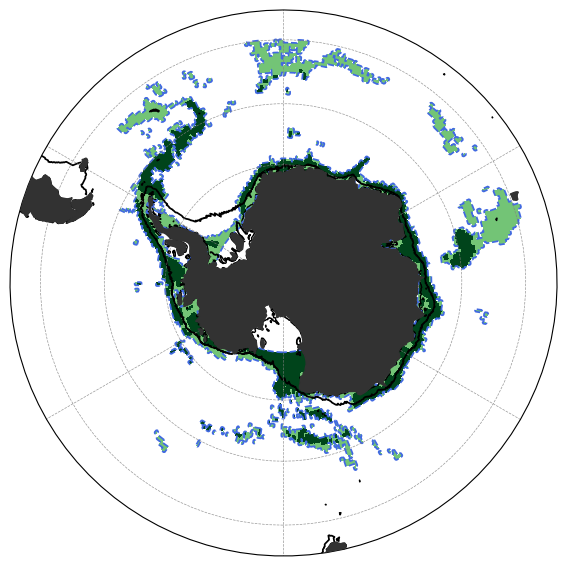

Trematomus loennbergii ...


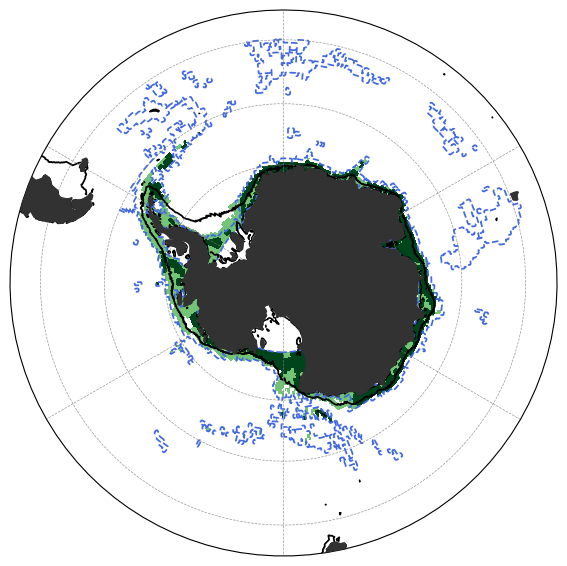

Macrourus whitsoni ...


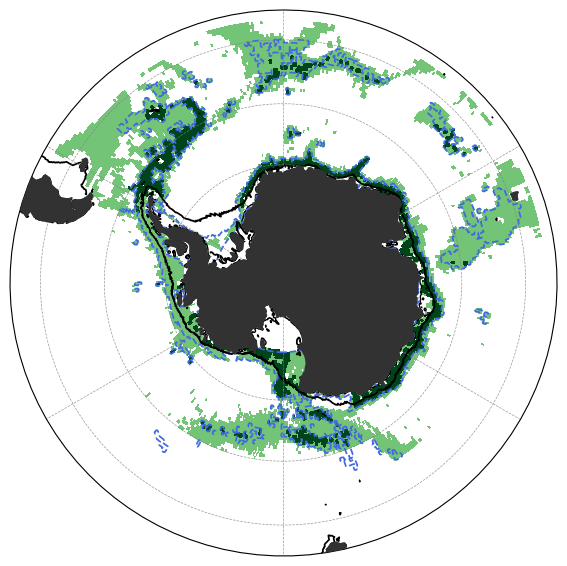

Galiteuthis glacialis ...


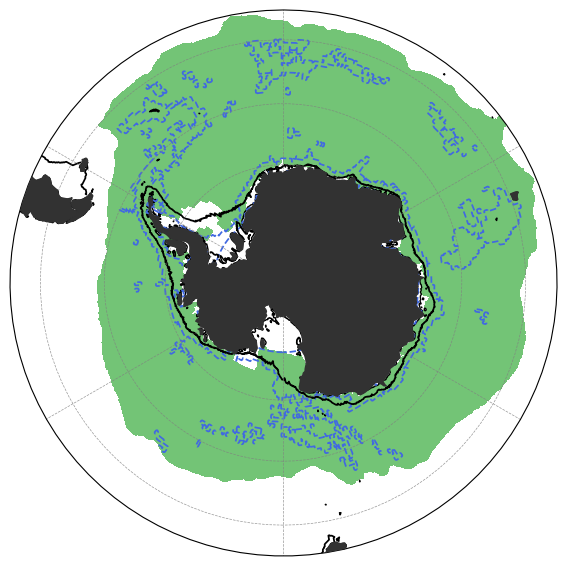

Chionodraco hamatus ...


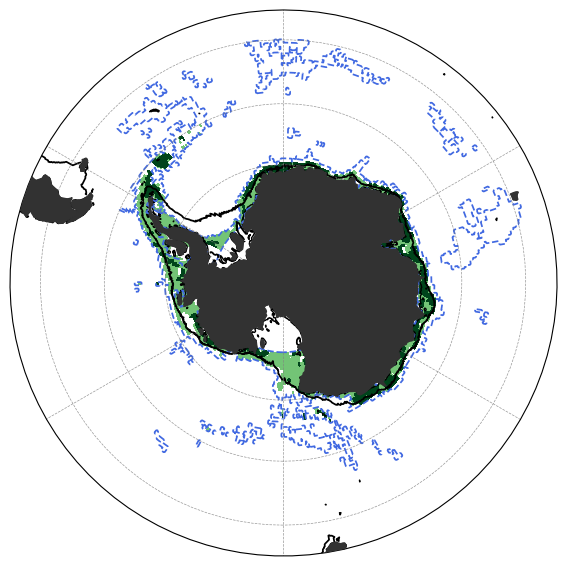

Anotopterus vorax ...


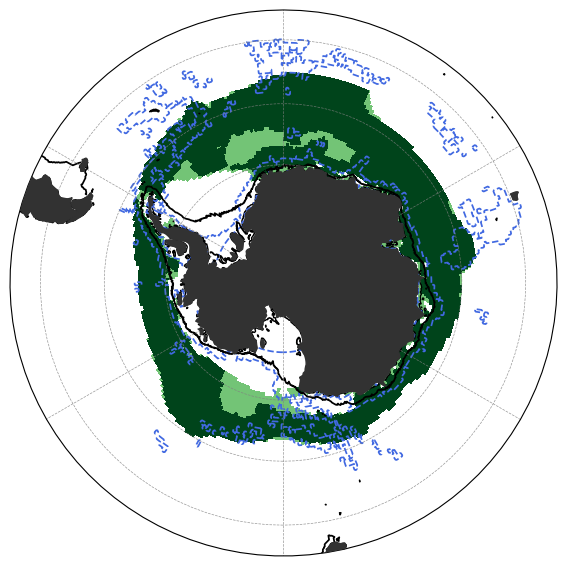

Chaenodraco wilsoni ...


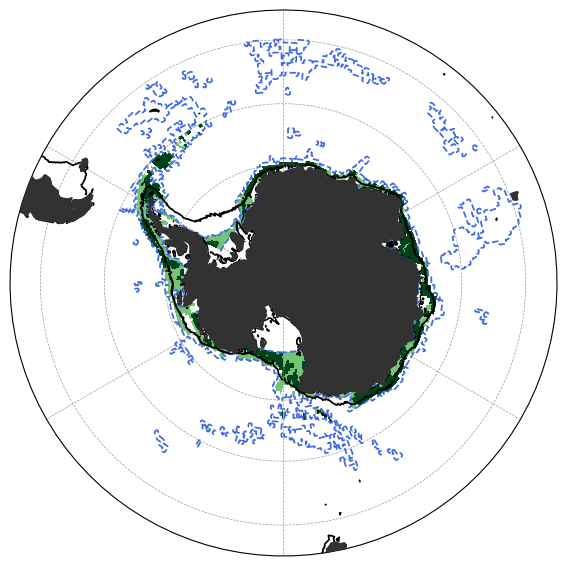

Kondakovia longimana ...


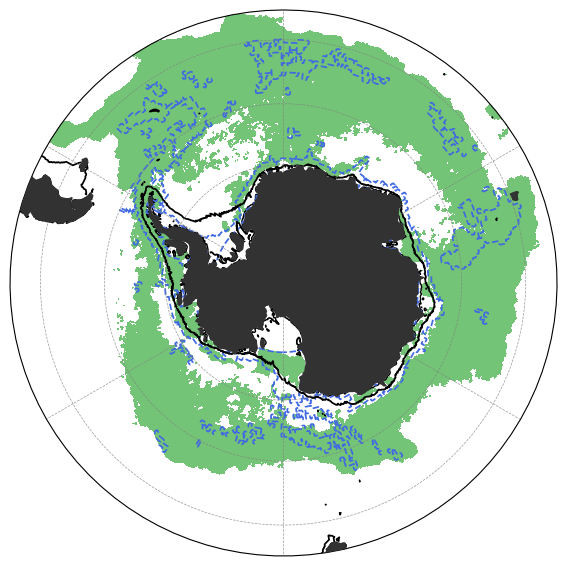

Cryodraco antarcticus ...


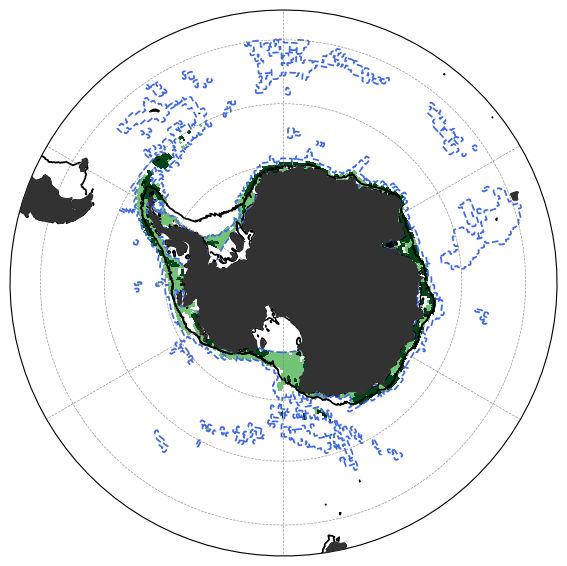

Muraenolepis microps ...


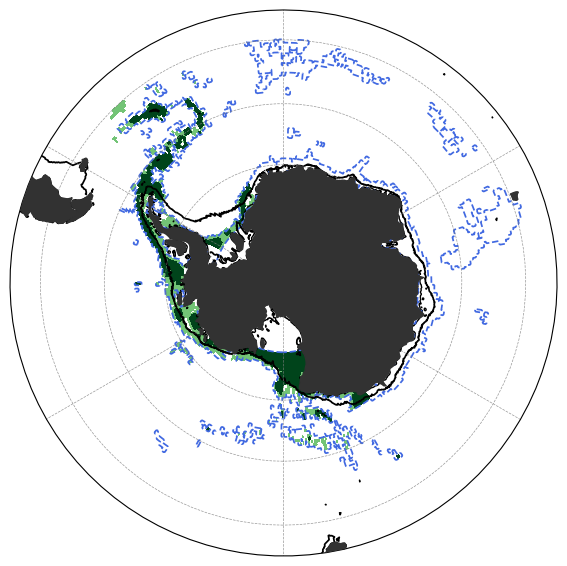

Psychroteuthis glacialis ...


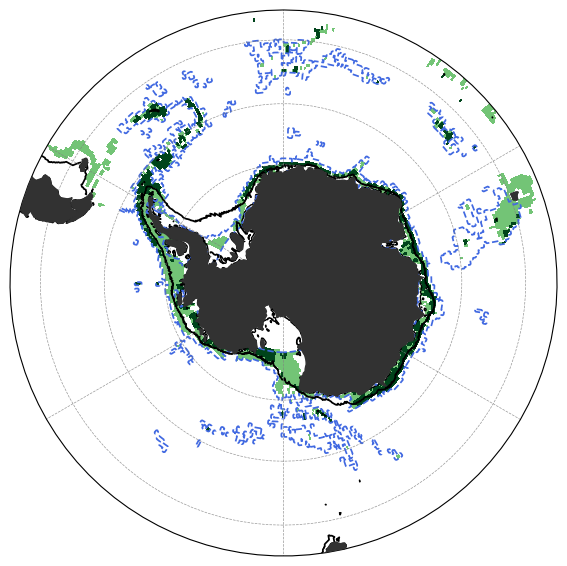

Gymnodraco acuticeps ...


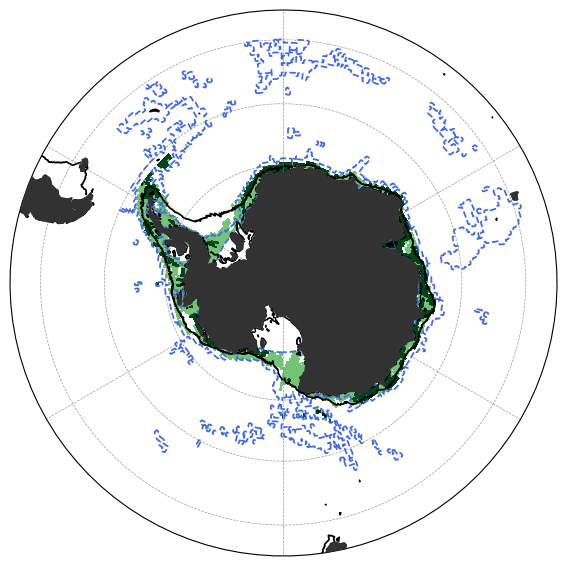

Amblyraja georgiana ...


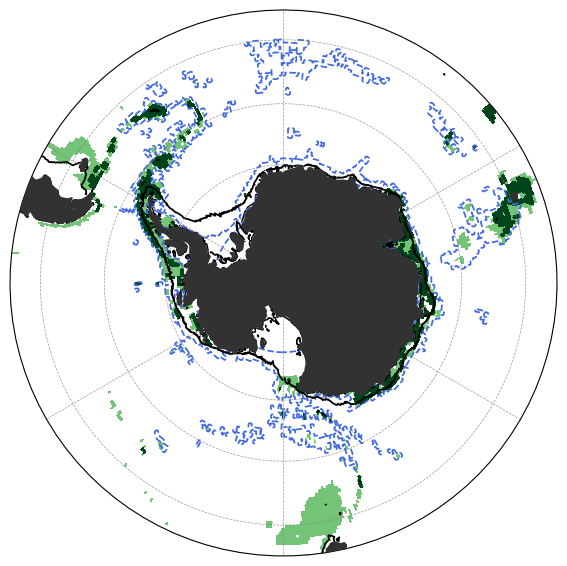

Antarctomysis maxima ...


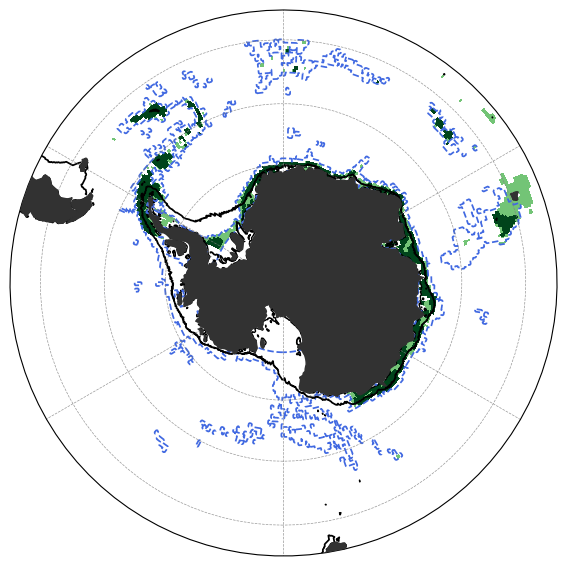

Lepidonotothen squamifrons ...


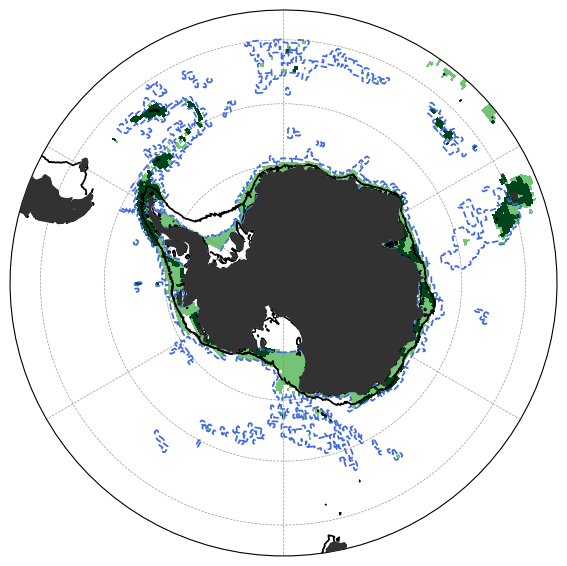

Mesonychoteuthis hamiltoni ...


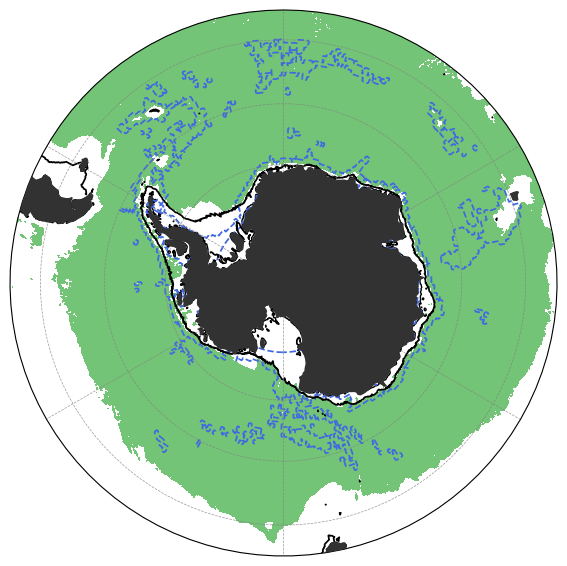

Pleuragramma antarctica ...


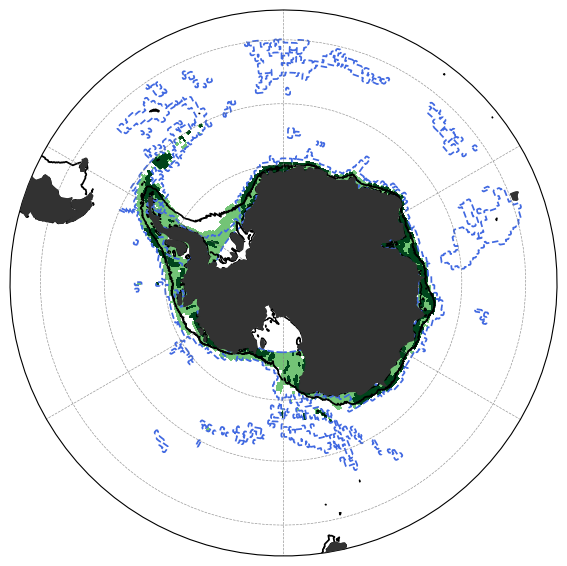

Euphausia superba ...


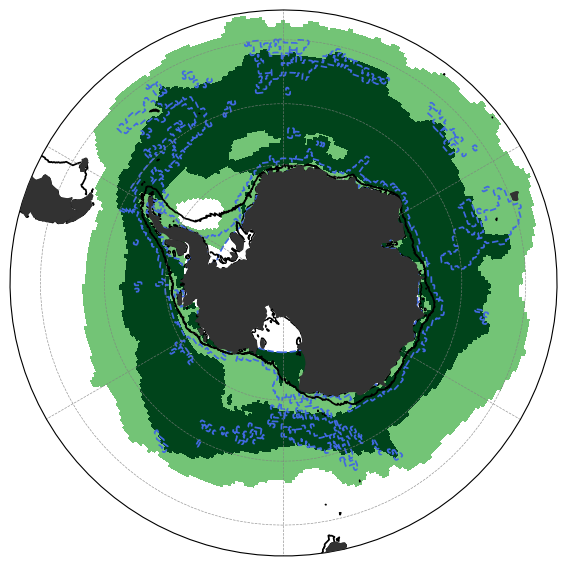

Notothenia coriiceps ...


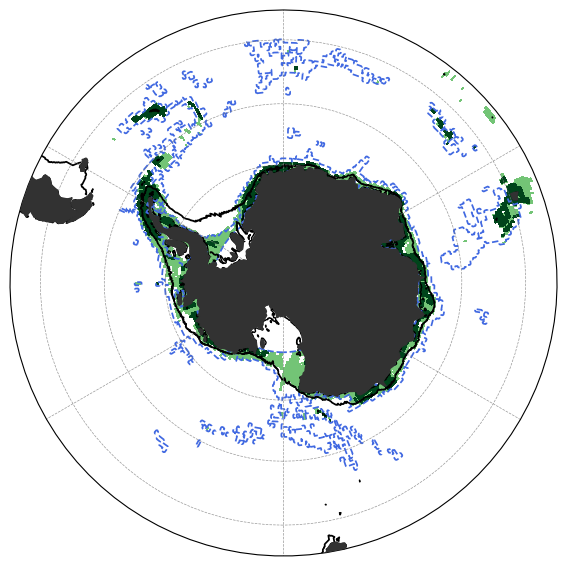

Trematomus lepidorhinus ...


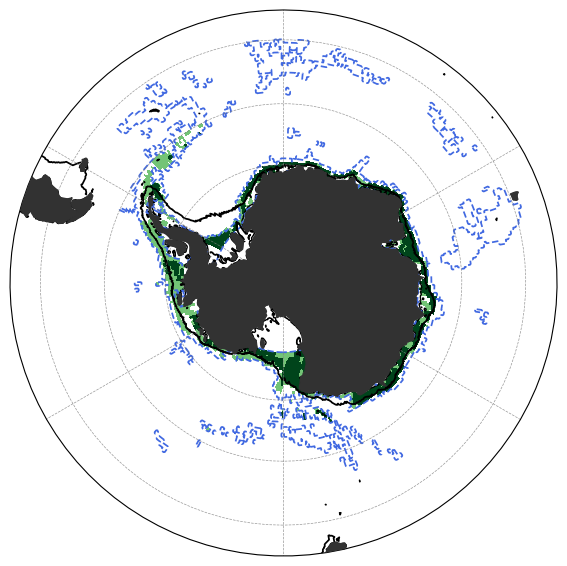

Pagothenia borchgrevinki ...


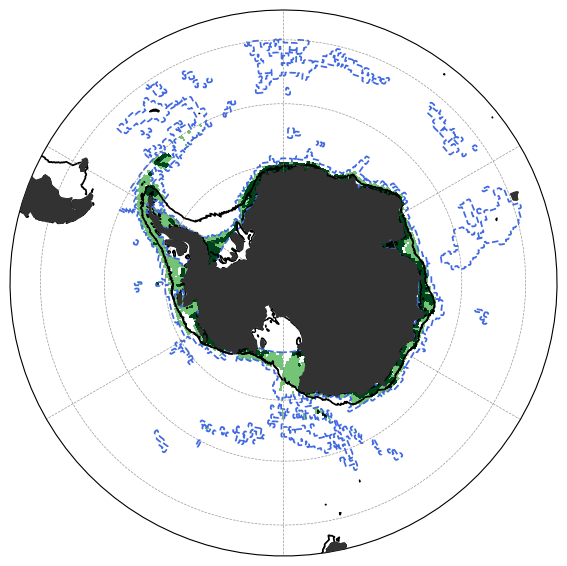

Lycenchelys aratrirostris ...


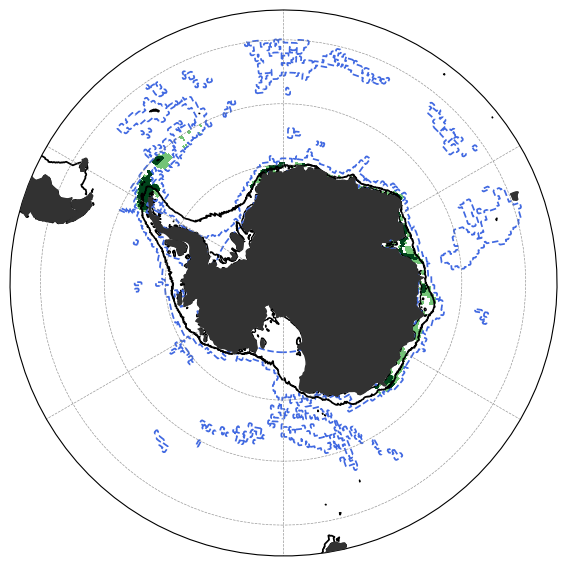

Neopagetopsis ionah ...


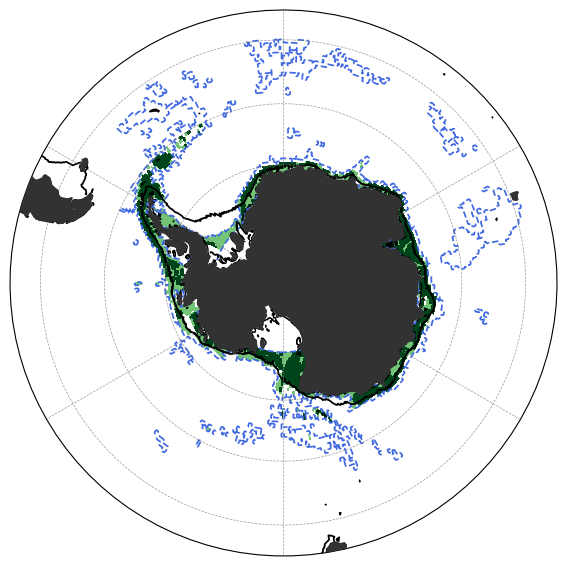

Chaenocephalus aceratus ...


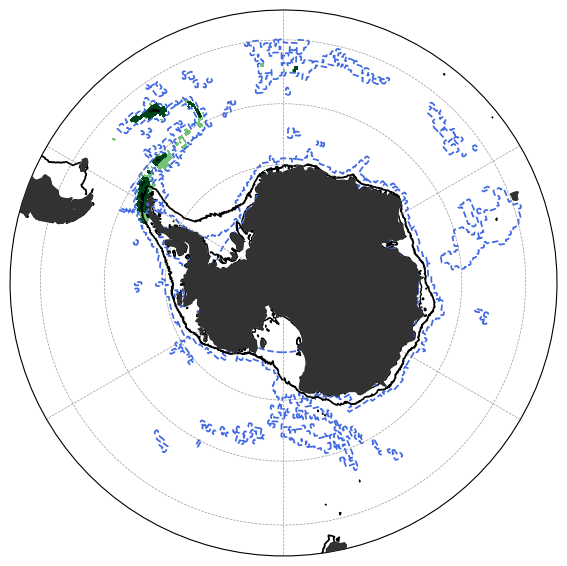

Trematomus hansoni ...


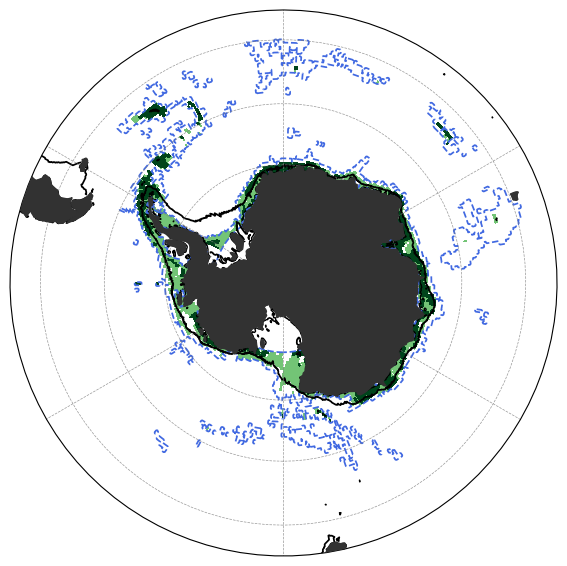

Chionobathyscus dewitti ...


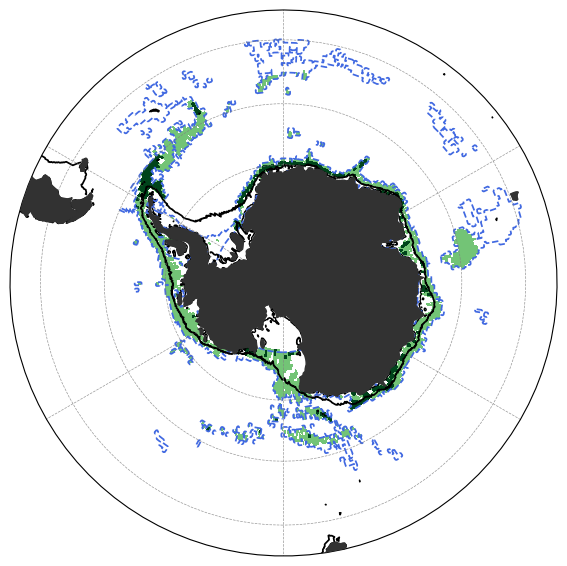

Euphausia crystallorophias ...


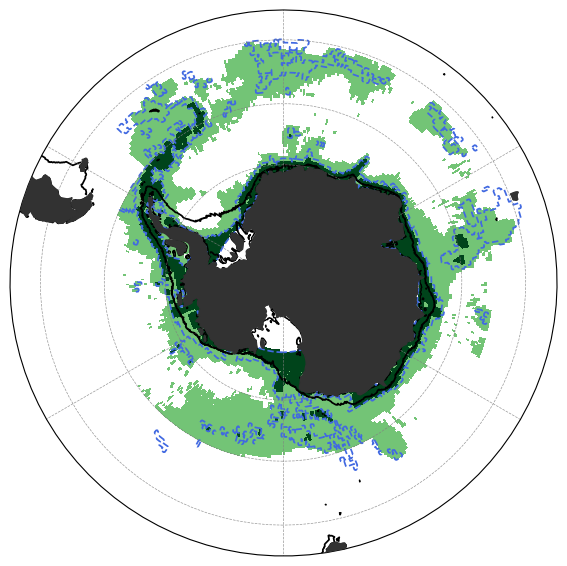

Notothenia rossii ...


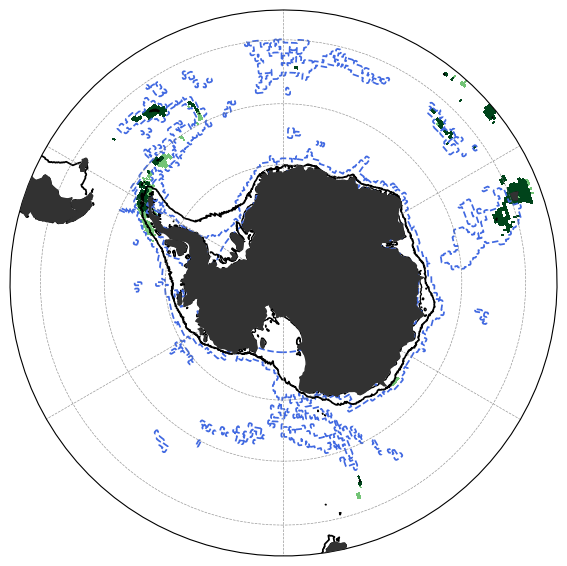

Bathyraja maccaini ...


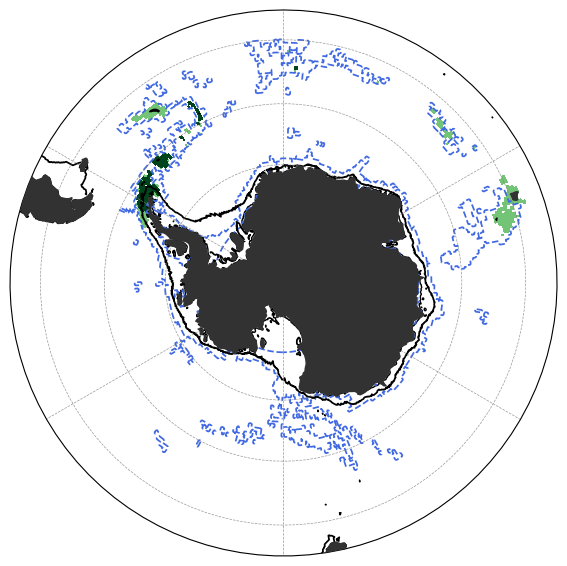

done


In [13]:
#---
# plot habitat for each species
#---

display_plots = True
save_plots = True

ind_tf = species_names.index('Dissostichus mawsoni')

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/habitat_maps/v2_two_thresholds/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
levels = np.arange(0,1+1,1)

# for plotting, correct some artefacts from dateline
topo2 = np.copy(topo)
topo2[:,-1] = topo2[:,0]
topo2[:,-2] = topo2[:,0]
topo2[:,-3] = topo2[:,0]

cmap1 = copy.copy(plt.cm.Greens) # RdYlBu_r, Greys
cmap1.set_under('w')  

cmap2 = copy.copy(plt.cm.Reds) # RdYlBu_r, Greys
cmap2.set_under('w')  
    
for pp in range(0,len(species_names)):
    print(species_names[pp],'...')
    data_plot1 = np.copy(habitat_all[:,:,pp])
    data_plot2 = np.copy(habitat_all2[:,:,pp])
    ind1 = np.where(data_plot1==1)[0]
    ind2 = np.where(data_plot2==1)[0]
    if ind1.shape[0]!=ind2.shape[0]: # only do this if the fields are actually different 
        # (for squid, they are the same, and I want the first color to be used in plotting!)
        data_plot1[data_plot2==1] = 2
    filename = 'Map_habitat_'+species_names_[pp]+'_thresholds_0.'+str(thresh)+'_0.'+str(thresh2)+'.png'
    plot_map(data_plot1,habitat_all[:,:,ind_tf],\
             topo2,lon,lat,cmap1,levels,save_plots,display_plots,savepath,filename)

print('done')


In [12]:
#print(data_plot2)

ind1 = np.where(data_plot1==1)[0]
ind2 = np.where(data_plot2==1)[0]
print(ind1.shape)
print(ind2.shape)


(2112,)
(1136,)


In [23]:
#print(plt.cm.Greens(0))

nn=120
print(plt.cm.Greens(nn)[0]*255,plt.cm.Greens(nn)[1]*255,plt.cm.Greens(nn)[2]*255)
nn=255
print(plt.cm.Greens(nn)[0]*255,plt.cm.Greens(nn)[1]*255,plt.cm.Greens(nn)[2]*255)


126.58823529411765 200.94117647058823 126.70588235294117
0.0 68.0 27.0


In [ ]:
#----
# v2 (for talk)
#----

In [ ]:
#---
# add cavity mask
#---

path = '/pscratch/sd/c/cnissen/shape_files/masks_MPAs/'

res = '0.025deg' # 0.025deg or 0.1dg or 0.5deg or 1deg

# cavity mask
ff = xr. open_dataset(path+'Mask_cavities_regular_mesh_0.025deg.nc')
cavities  = ff['mask_cavities'].values
cavities = np.ma.masked_where(cavities>10,cavities)
#topo  = ff['topo'].values
#topo = np.ma.masked_where(topo>9999,topo)
##topo = np.ma.masked_where(cavities==1,topo)
ff.close()

ff = xr. open_dataset(path+'MPA_mask_AntarcticPeninsula_regular_mesh_'+res+'.nc')
#lon_cav  = ff['lon'].values
lat_cav  = ff['lat'].values
mask_peninsula  = ff['mask_mpa'].values
ff.close()

res = 0.025
lon1 = np.arange(-180+res,(180-res)+res,res) 
cavities2,lon_cav = add_cyclic_point(cavities,coord=lon1)


In [ ]:
#----
# plotting function -> for talk
#----
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
import copy
import matplotlib.colors

def plot_map_v2(data,data_tf,topo,lon,lat,lon_cav,lat_cav,cavities,cmap1,levels,save_plots,display_plots,savepath,filename):
    #cmap1.set_under('w')

    fs = 10
    lw = 2
    plot_colorbar = False
    
    projection=ccrs.SouthPolarStereo()
    
    fig = plt.figure(figsize=(24,18))
    ax = fig.add_subplot(1, 3, 2, projection=projection)
    ax.set_extent([-280, 80, -80, -47], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=(50./255.,50./255.,50./255.),zorder=50)  #"grey"
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.outline_patch.set_edgecolor(None) # white
    
    colors2 = matplotlib.colors.ListedColormap([(255./255.,255./255.,255./255.),(60./255.,179./255.,113./255.),\
                                            (60./255.,179./255.,113./255.),(60./255.,179./255.,113./255.)])
    # mediumseagreen 60,179,113
    mm1=ax.contourf(lon,lat, data,levels=levels,extend='both',cmap=colors2,transform=ccrs.PlateCarree())    
    
    lw = 1.25
    
    # toothfish habitat
    #'royalblue', ,linestles=['-']
    mm1=ax.contour(lon,lat, data_tf,levels=[1],colors=['black'],linewidths=[lw],linestles=[':'],\
                   transform=ccrs.PlateCarree())   
    
    # topo
    #print(lon.shape,lat.shape,topo.shape)
    mm1=ax.contour(lon,lat, topo,levels=[1000],colors=['black'],linewidths=[lw],\
                   transform=ccrs.PlateCarree())   
    
    # cavity
    levels1 = np.arange(0,3,1)
    colors2 = matplotlib.colors.ListedColormap([(218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.),\
                                            (218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.)])
    #print(lon_cav.shape,lat_cav.shape,cavities.shape)
    mm1=ax.contourf(lon_cav, lat_cav, cavities,\
               levels=levels1,extend='both',cmap=colors2,transform=ccrs.PlateCarree(),zorder=49)

    
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([])#-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([])#-70,-60,-50])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    dpicnt = 150

    if save_plots:
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')

    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        


In [ ]:
#---
# plot habitat for each species
#---

display_plots = True
save_plots = True

ind_tf = species_names.index('Dissostichus mawsoni')

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/habitat_maps/v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
levels = np.arange(0,1+1,1)

# for plotting, correct some artefacts from dateline
topo2 = np.copy(topo)
topo2[:,-1] = topo2[:,0]
topo2[:,-2] = topo2[:,0]
topo2[:,-3] = topo2[:,0]

cmap1 = copy.copy(plt.cm.Greens) # RdYlBu_r, Greys
cmap1.set_under('w')   
    
for pp in range(0,1):#len(species_names)):
    print(species_names[pp],'...')
    filename = 'Map_habitat_'+species_names_[pp]+'_for_talk.png'
    plot_map_v2(habitat_all[:,:,pp],habitat_all[:,:,ind_tf],topo2,lon,lat,lon_cav,lat_cav,cavities2,cmap1,\
                levels,save_plots,display_plots,savepath,filename)

print('done')


In [ ]:
print(savepath)